## Getting the data


In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sc

sns.set_theme()

In [3]:
housing = pd.read_csv("./datasets/housing/housing.csv")

## Initial Exploratory Data Analysis


First steps of the EDA:

- head
- info
- value_counts of categorical features
- summary statistics (.describe), histograms of numerical variables


In [4]:
housing.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [5]:
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


A column with a dtype='object' could hold any kind of python object. However since this data comes from a csv file, we know it must be a text attribute.


In [6]:
housing["ocean_proximity"].value_counts()


ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing["ocean_proximity"] = housing["ocean_proximity"].astype("category")
housing["ocean_proximity"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 20640 entries, 0 to 20639
Series name: ocean_proximity
Non-Null Count  Dtype   
--------------  -----   
20640 non-null  category
dtypes: category(1)
memory usage: 20.5 KB


In [8]:
# By default, .describe ignores non-numerical columns, and null values.
housing.describe()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


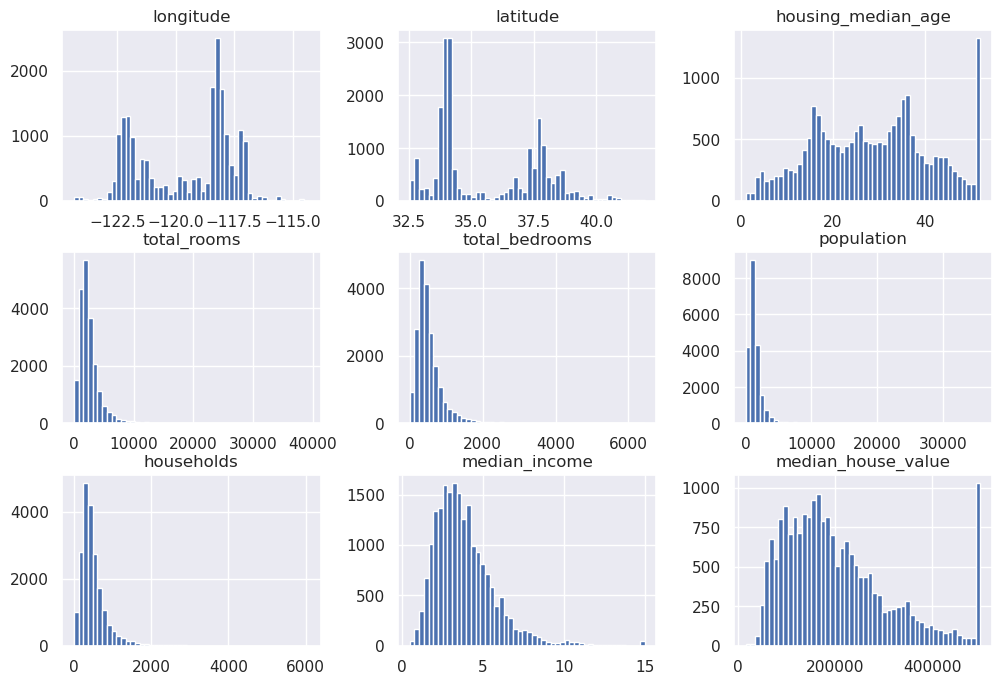

In [9]:
housing.hist(bins=50, figsize=(12, 8))
plt.show()

- Median income is expressed in tens of thousands of dollars
- House value and age are capped
- Most histograms are heavily skewed to the right


In [10]:
# Before modifying the dataset, we'll make sure we keep a copy of the original
housing_original = housing.copy()


## Create a test set


If you do a very extensive EDA before creating a test set, your run into the risk of data snooping: manually detecting patterns in the dataset, which bias your model selection and lead to overfitting.


### Simplest way


In [11]:
# Simplest way to do the train-test split
from sklearn.model_selection import train_test_split

train_test, test_set = train_test_split(housing, test_size=0.2, random_state=0)

Fixing the random state keeps the train and test sets constant every time we run the cell. However, they won't be constant if we fetch and updated dataset.


### Splitting by id


In [12]:
# Keeping the split constant when we upload the dataset
from sklearn.model_selection import GroupShuffleSplit

# Create an ID column
# We must include the value because the longitude and latitude are not unique by themselves
housing["id"] = (
    housing[["longitude", "latitude", "median_house_value"]].sum(axis=1).map(hash)
)
# Check if the id is unique
num_of_unique_ids = housing["id"].value_counts().sum()
print(num_of_unique_ids / len(housing))
# Use the splitter GroupShuffleSplit to split by id
splitter = GroupShuffleSplit(test_size=0.20, n_splits=2, random_state=0)
split = splitter.split(housing, groups=housing["id"])
train_indexes, test_indexes = next(split)
train_set = housing.iloc[train_indexes]
test_set = housing.iloc[test_indexes]

# drop the id column
housing.drop("id", axis=1, inplace=True)

1.0


### Stratified Sampling


The most relevant features should have approximately the same distribution in the test set as in the whole dataset. In huge test sets, this is achieved by pure chance and there is no need to apply stratified sampling. In small test sets however, there is a big chance that distribution of the features will be significantly different from the one in the whole dataset. IN this case you should use stratified sampling to make sure that the test set is representative of the whole dataset.

Stratified sampling: method of sampling that ensures that the 'strata', i.e. the possible values of some categorical feature, have the same relative frequencies in the test set as they do in the whole dataset.

To apply stratified sampling to a continuous variable, you must discretize it (bin it) first.


<Axes: >

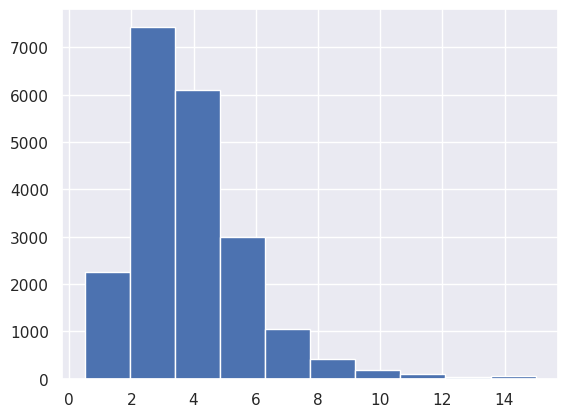

In [13]:
# The most important feature of the housing dataset is median house income.

# Get the histogram of the median house income to decide a reasonable binning
housing["median_income"].hist()

In [14]:
# Discretize the variable with pd.cut
housing["income_category"] = pd.cut(
    housing["median_income"],
    bins=[0, 1.5, 3, 4.5, 6, np.inf],
    labels=["lt_15k", "15_to_30k", "30_to_45k", "45_to_60k", "mt_60k"],
)

In [15]:
# Do the stratified train test split
train_set, test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_category"], random_state=0
)

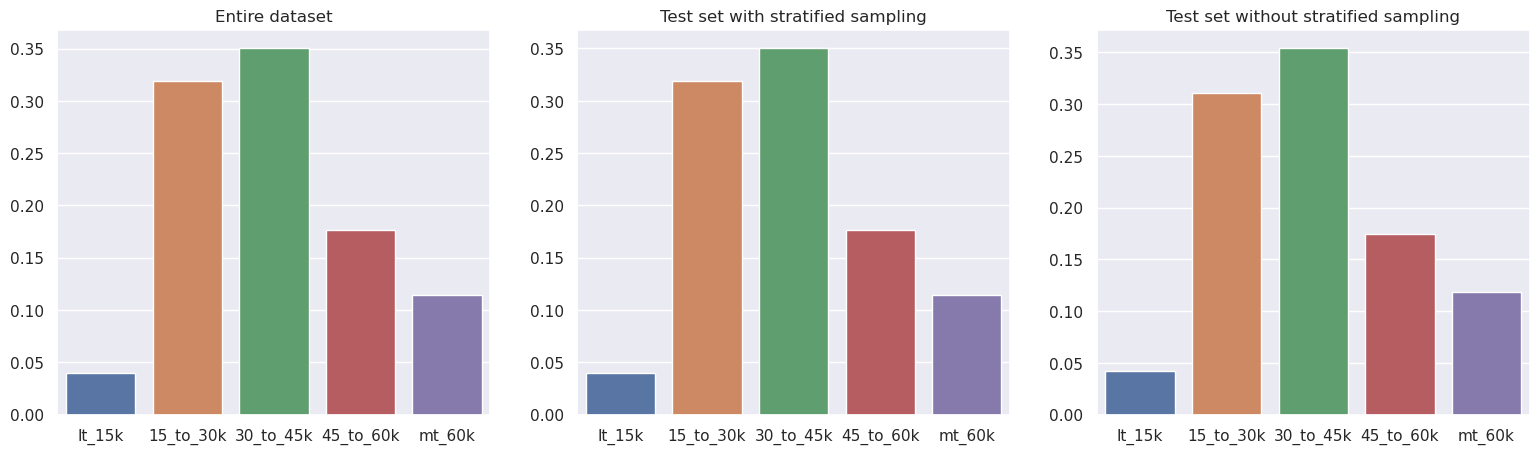

,Income category,Entire dataset,Test set (stratified),Test set (non-stratified)
0,lt_15k,3.98,4.00,4.24
1,15_to_30k,31.88,31.88,31.08
2,30_to_45k,35.06,35.05,35.42
3,45_to_60k,17.63,17.64,17.47
4,mt_60k,11.44,11.43,11.80


In [16]:
# Do a stratified and non stratified train test split
train_set_non_stratified, train_set_non_stratified = train_test_split(
    housing, test_size=0.2, stratify=None, random_state=1
)
train_set_stratified, test_set_stratified = train_test_split(
    housing, test_size=0.2, stratify=housing["income_category"], random_state=0
)

# Compare the relative counts in the test set to the ones in the whole dataset
figure, axis = plt.subplots(1, 3, figsize=(19, 5))
table = pd.DataFrame()

# Entire
relative_frequency_series = (
    housing["income_category"].value_counts(normalize=True).sort_index()
)
category = relative_frequency_series.index.to_numpy()
relative_frequency = relative_frequency_series.values
sns.barplot(ax=axis[0], x=category, y=relative_frequency)
axis[0].set_title("Entire dataset")
table["Income category"] = category
table["Entire dataset"] = relative_frequency * 100

# Test set
relative_frequency_series = (
    test_set_stratified["income_category"].value_counts(
        normalize=True).sort_index()
)
category = relative_frequency_series.index.to_numpy()
relative_frequency = relative_frequency_series.values
sns.barplot(ax=axis[1], x=category, y=relative_frequency)
axis[1].set_title("Test set with stratified sampling")
table["Test set (stratified)"] = relative_frequency * 100

# Test set
relative_frequency_series = (
    train_set_non_stratified["income_category"]
    .value_counts(normalize=True)
    .sort_index()
)
category = relative_frequency_series.index.to_numpy()
relative_frequency = relative_frequency_series.values
sns.barplot(ax=axis[2], x=category, y=relative_frequency)
axis[2].set_title("Test set without stratified sampling")
table["Test set (non-stratified)"] = relative_frequency * 100


plt.show()
table.round(2).head()


## More extensive Exploratory Data Analysis


### Intro


Once we have created the train-test split, we can safely explore the training set without fear of data snooping.


In [17]:
# We'll use the stratified training set
housing = train_set_stratified.copy()

# We won't use the income categories anymore
housing.drop("income_category", axis=1, inplace=True)


### Visualize geographical data


<Axes: xlabel='longitude', ylabel='latitude'>

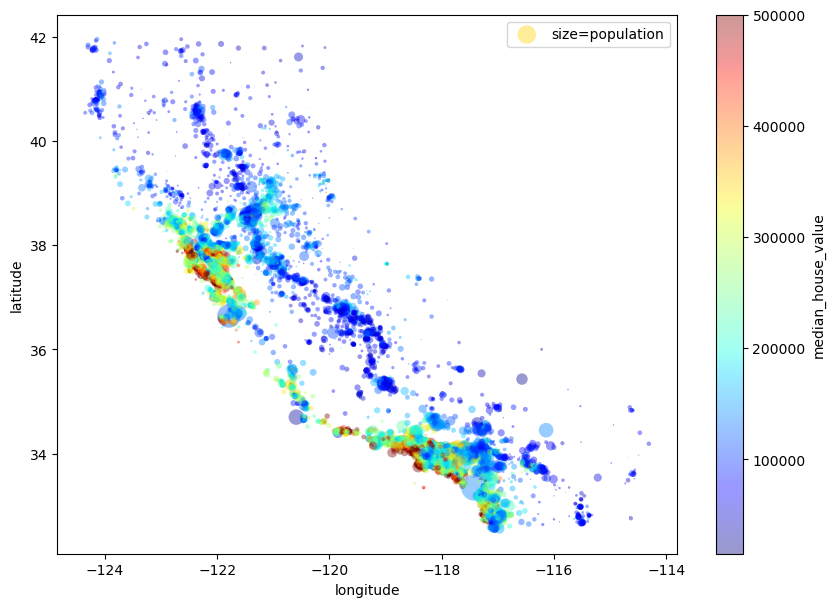

In [18]:
# The latitude and longitude columns make it very easy to plot a geographical map
plt.style.use("default")
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    c="median_house_value",
    s=housing["population"] / 100,
    label="size=population",
    figsize=(10, 7),
    alpha=0.4,
    cmap="jet",
    linewidths=0,
    legend=True,
)

### Look for correlations


In [19]:
correlation_matrix = housing.corr(numeric_only=True)
correlation_matrix["median_house_value"]

longitude            -0.043646
latitude             -0.146286
housing_median_age    0.104135
total_rooms           0.137121
total_bedrooms        0.051855
population           -0.023735
households            0.068079
median_income         0.691450
median_house_value    1.000000
Name: median_house_value, dtype: float64

The only variable that is strongly correlated with the house value is the income.


<Axes: xlabel='median_income', ylabel='median_house_value'>

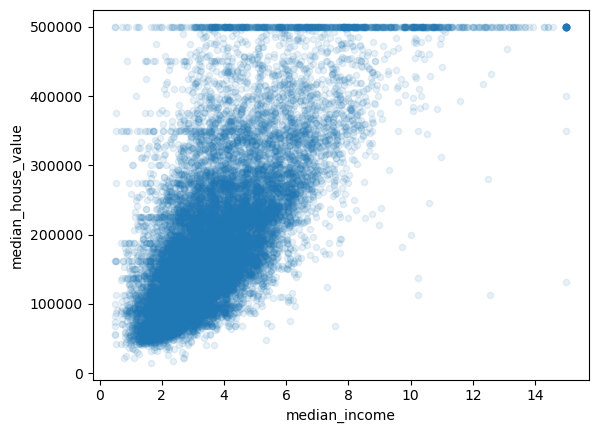

In [20]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

Fixed lines at 450_000, 350_000 maybe remove them later.


<Axes: >

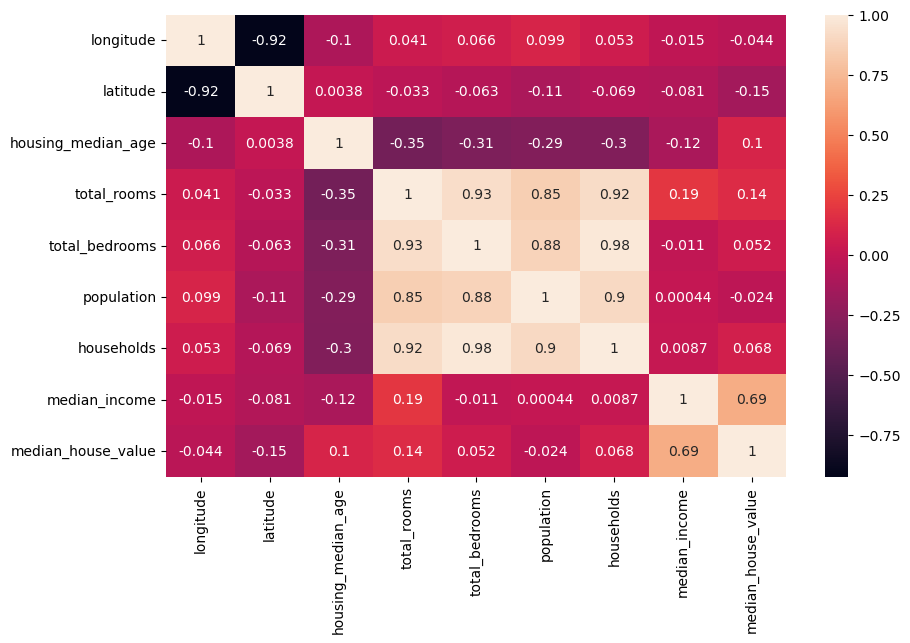

In [21]:
figure, axis = plt.subplots(figsize=(10, 6))
sns.heatmap(
    correlation_matrix,
    xticklabels=correlation_matrix.columns.values,
    yticklabels=correlation_matrix.columns.values,
    annot=True,
)

There is a very strong correlation between the total rooms, bedrooms, households and population. Let's combine this to make better attributes


### Combine multiple attributes


In [22]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [23]:
correlation_matrix = housing.corr(numeric_only=True)
correlation_matrix["median_house_value"]

longitude            -0.043646
latitude             -0.146286
housing_median_age    0.104135
total_rooms           0.137121
total_bedrooms        0.051855
population           -0.023735
households            0.068079
median_income         0.691450
median_house_value    1.000000
rooms_per_house       0.153476
bedrooms_per_room    -0.259353
people_per_house     -0.021680
Name: median_house_value, dtype: float64

This turned out to be much better attributes. The number of rooms per house and bedrooms per room are correlated with house value.


This round of exploration does not need to be absolutely thorough. The point is to gain a few insights that you can use when you train the model. Also, you can always come back to this step and iterate once you have a working prototype.


## Prepare the data for Machine Learning Algorithms


### Intro


You should write **data transformation functions** instead of doing the transformations manually. This has several benefits: you can apply the same transformations to a new or updated dataset, you will build up a personal library of useful data transformation functions, you can try out multiple combinations of different transformations.


In [24]:
from sklearn.model_selection import train_test_split

# Start from the original dataset
housing = housing_original.copy()

X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

X["income_category"] = pd.cut(
    housing["median_income"],
    bins=[0, 1.5, 3, 4.5, 6, np.inf],
    labels=["lt_15k", "15_to_30k", "30_to_45k", "45_to_60k", "mt_60k"],
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=X["income_category"]
)

for df in [X_train, X_test]:
    df.drop("income_category", axis=1, inplace=True)

### Missing values


In this treatment we are assuming that there are no missing values in the 'y' dataset. This must be true by definition in a labeled dataset.

There are multiple options for dealing with missing values:


In [25]:
df = pd.DataFrame({"column1": [0, 2, 3, np.nan, 1, 2, 3, np.nan]})

# Drop the missing values
df["column1"].dropna(inplace=True)

# Drop the column with the missing values
df.drop("column1", axis=1)

# Fit the missing values with some value (e.g. median, mean, most common, constant...). This is called imputation.
# In this case we'll use the mediaN
median = df["column1"].median()
df["column1"].fillna(median, inplace=True)


If you decide to go for option 3 (replacing the nan with some value) the most optimal choice is to do it with scikit learn. More specifically, you should use an Imputer class like SimpleImputer, KNNImputer, or IterativeIMputer. Using sklearn makes it possible to also replace the missing values on new data, and it allows for more complex strategies, such as knn.


In [26]:
from sklearn.impute import SimpleImputer
from sklearn import set_config

# Set the default output of transformers to be a pandas data frame
set_config(transform_output="pandas")

# Split the training set into categorical and numerical data
X_train_numerical = X_train.select_dtypes(include=[np.number])
X_train_categorical = X_train.select_dtypes(include="category")

# NUMERICAL DATA -> fill na with median
# Create an instance of the simple imputer and specify how you want to fill the missing values
imputer_num = SimpleImputer(strategy="median")
# Train the imputer (this computes the median of the training data)
imputer_num.fit(X_train_numerical)
# The calculated medians are stored on its statistics_ public instance variable
print(imputer_num.statistics_)
# Transform the numerical training set
X_train_numerical = imputer_num.transform(X_train_numerical)

# CATEGORICAL DATA -> fill na with most common value
# Create an instance of the simple imputer and specify how you want to fill the missing values
imputer_cat = SimpleImputer(strategy="most_frequent")
# Train the imputer (this computes the median of the training data)
imputer_cat.fit(X_train_categorical)
# The calculated medians are stored on its statistics_ public instance variable
print(imputer_cat.statistics_)
# Transform the numerical training set
X_train_categorical = imputer_cat.transform(
    X_train_categorical).astype("category")

# Join the two sets
X_train = X_train_numerical.join(X_train_categorical)


[-118.51      34.26      29.      2127.       435.      1164.
  409.         3.53495]
['<1H OCEAN']


In class we were told that the best option is often the KNNImputer.


In [27]:
from sklearn.impute import KNNImputer
from sklearn import set_config

# Set the default output of transformers to be a pandas data frame
set_config(transform_output="pandas")

# Example data frame
df = pd.DataFrame({"column1": [0, 2, 3, np.nan, 1, 2, 3, np.nan]})

# Use the imputer
imputer = KNNImputer()  # all the default hyperparameters
df = imputer.fit_transform(df)


Transformers have a convenience method called fit_transform that fits the imputer to that dataset at then transforms it. Sometimes it is optimized to run much faster than the two step fit+transform.


Never fit anything (estimators) to the test data. Fit the estimator to the training data, then transform / predict the test data.


**\* Missing sklearn design section of p70**


### Transform categorical data to numbers


Almost all machine learning algorithms rather work with numbers than text. We should convert the categorical attributes from text to numbers.


#### Ordered categories: ordinal encoding


Change each element of the list of categories by their index: ['A', 'B', 'C', ...] -> [0,1,2, ...]

This method assumes an ordered category: two nearby values are more similar than two distant ones. ['bad', 'good', 'very good'] is an ordered category, ['cat', 'dog', 'horse'] is an unordered category.


In [28]:
from sklearn.preprocessing import OrdinalEncoder

df = pd.DataFrame({"ordered_category": ["bad", "good", "very good"]})
ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit_transform(df)


,ordered_category
0,0.0
1,1.0
2,2.0


#### Unordered categories: one hot encoding


Create one binary attribute per category.

One hot encoding results in a large matrix of ones and zeros. By default, the transform output is a Scipy sparse matrix, which is a data structure that is optimized so that it only stores the positions of the ones. Using a dense numpy or pandas matrix is more performance intensive. Obviously the more data you are working with the most important this is, so you should pay special attention when working with lots of dummy variables or a huge dataset.


In [29]:
from sklearn.preprocessing import OneHotEncoder

sk.set_config(
    transform_output="default"
)  # Ensure the output of the transformer is a sparse matrix
one_hot_encoder = OneHotEncoder()
one_hot_matrix = one_hot_encoder.fit_transform(X_train_categorical)
one_hot_matrix


<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [30]:
# get the categories
print(one_hot_encoder.categories_)

# Convert the matrix to numpy to see what it looks like
one_hot_matrix.toarray()

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [31]:
# Cast the sparse matrix to a pandas DataFrame
X_train_categorical_oh = pd.DataFrame(
    one_hot_matrix.toarray(),
    columns=one_hot_encoder.get_feature_names_out(),
    index=X_train_categorical.index,
)
X_train_categorical_oh


,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
1339,1.0,0.0,0.0,0.0,0.0
15531,0.0,1.0,0.0,0.0,0.0
12136,1.0,0.0,0.0,0.0,0.0
14340,0.0,1.0,0.0,0.0,0.0
582,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
18734,0.0,1.0,0.0,0.0,0.0
9324,1.0,0.0,0.0,0.0,0.0
4772,0.0,0.0,0.0,1.0,0.0
15889,1.0,0.0,0.0,0.0,0.0


**Why not use pandas.DataFrame.get_dummies ?**

Scikit's one hot encoder remembers the categories in which it was trained on, pandas' get dummies does not. If you feed pandas a new categorical value that it has never seen before, it will simply create a new column without checking anything. If the test set has a new value that did not appear in the training set, pandas will accept it and by the end of the data transformation process the ML model will be fed different features than the ones that were used in training. This is a terrible bug.

On the other hand, scikit's one hot encoder can be configured to either ignore the new value, resulting in a row with all zeroes, ot to raise a very readable error.


**Unordered categories with a large number of possible values**

In this case one hot encoding is not practical. A possible solution is to replace the categorical feature with useful numerical features that are related to it. For example, you can change a country's name with its population and GDP. Alternatively, you can use more complex encoders or apply embedding.


### Feature scaling


Most machine learning models don't perform well when the attributes have very different scales. They will tend to overrepresent the effect of the features with the largest scales. Feature scaling is the process of transforming the attributes so that they all have a similar scale. The two most common methods used to achieve this are min-max scaling and standardization.


#### Key notes


- sparse matrices

  Sometimes you may want to apply a transformer to a sparse matrix without converting it to a dense numpy or pandas matrix first. On this case you must be specially careful that none of the transformation automatically convert it, for example, the StandardScaler will do exactly this unless you specify with_mean = False, because its impossible to subtract the mean to every value without breaking sparsity.

- Never fit anything to the test-validation set. Only fit the training set.

  All this transformer should be fitted to the training set and then applied to transform the training, validation and test set. They should never be fit to the test set. This is a general principle, not just one for sk's transformes: only fit to the training set.


#### Mim-max scaling (a.k.a. Normalization)


This is the simplest method. Let the range after normalization be [A, B], then:

$$
x_{norm} = \frac{x-x_{min} }{x_{max}-x_{min}}  (B - A) +A, \quad \implies x_{norm} \in  [A, B],  \forall  x
$$

but they can be rescaled to any range.

Min-max scaling is a linear transformation that rescales the values to an arbitrary range.

This method of scaling is susceptible to outliers, do to the fact that it is a linear transformation. For example if all the values range from [0,15) before normalization but there is one outlier at 100, then mim-max scaling would crush all the values but one to the range [0, 0.15).


In [33]:
from sklearn.preprocessing import MinMaxScaler

df = pd.DataFrame({"column1": np.linspace(0, 100, 1000)})
sk.set_config(transform_output="pandas")

min_max_scaler = MinMaxScaler(
    feature_range=(0, 1)
)  # The most common strategy is to use feature_range = (0,1) or (-1,+1)
df = min_max_scaler.fit_transform(df)

df.describe()


,column1
count,1000.000000
mean,0.500000
std,0.289109
min,0.000000
25%,0.250000
50%,0.500000
75%,0.750000
max,1.000000


#### Standardization


Let $ \nu $ be the mean, and $ \sigma $ be the standard deviation of the values in the j-th column ,$x_j$, then

$$
x_{std} = \frac{x-\nu}{\sigma}
$$

This method does not restrict values to a specific range, which makes it less susceptible to outliers: and outlier will simply be a few standard deviations outside of the mean, but it won't affect the scaling of the other values in any way.


In [37]:
from sklearn.preprocessing import StandardScaler

sk.set_config(transform_output="pandas")
df = pd.DataFrame({"x": np.linspace(-100, 100, 1000)})

standard_scaler = StandardScaler()
df = standard_scaler.fit_transform(df)


### Feature transformation


A heavy tail distribution is any distribution where the values far away from the mean are not exponentially more rare. Roughly speaking a heavy tail distribution can be identified if the histogram does not look like a Gaussian. When applied to this kinds of distributions, in-max and standard scaling tend to squeeze most values inside a small range, which is something that ML models dislike. In this case we should transform the features before scaling them .The goal is to transform the distribution to (something close to) a Gaussian.


#### Heavy Tail distributions


**Take square root or log**

Most heavy tail distributions are right skewed distributions with all positive values, e.g. gdp per capita, income, ..., In this case the best strategy often is to take the square root of the values (more generally to raise them to a power between 0 and 1) or to take their logarithm.


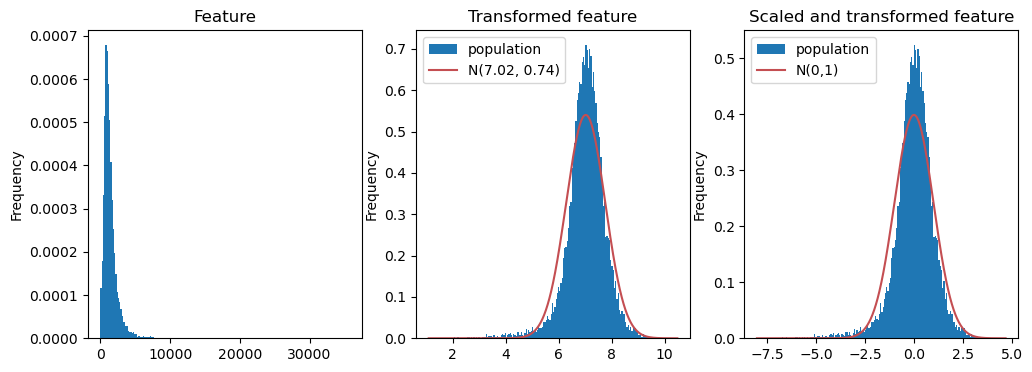

In [95]:
from scipy import stats

figure, axis = plt.subplots(1, 3, figsize=(12, 4))

# Raw feature
df = pd.DataFrame({"population": housing["population"]}, index=housing.index)
df["population"].plot(kind="hist", bins=200, ax=axis[0], density=1)
axis[0].set_title("Feature")

# Transformed feature
df["population"] = np.log(df["population"])
df["population"].plot(kind="hist", bins=200, ax=axis[1], density=1)
axis[1].set_title("Transformed feature")

# Compare that to a normal distribution
x = np.linspace(df["population"].min(), df["population"].max(), 1000)
mean = df["population"].mean()
std = df["population"].std()
axis[1].plot(
    x, stats.norm.pdf(x, mean, std), c="r", label=f"N({round(mean,2)}, {round(std,2)})"
)
axis[1].legend()

# Finally we can scale the transformed feature
standard_scaler = StandardScaler()
df = standard_scaler.fit_transform(df)
df["population"].plot(kind="hist", bins=200, ax=axis[2], density=1)
axis[2].set_title("Scaled and transformed feature")

# Compare that to the normal distribution N(0,1)
x = np.linspace(df["population"].min(), df["population"].max(), 1000)
axis[2].plot(x, stats.norm.pdf(x, 0, 1), c="r", label="N(0,1)")
plt.legend()

**Bucketize the feature**

We have already covered bucketizing in stratified sampling. A common strategy is to replace the values by their percentile. The output should be a discrete numerical value, i.e. an integer, like in the case of ordered categories.


#### Multimodal distributions


**Simple bucketization**

You can just bucketize the variable and use the discrete categories instead of the continuous feature. For example, let's say the housing_median_age column is multimodal. ML algorithms don't like non-Gaussian distributions and they won't do a good job on the multimodal feature. However we could bucketize it in 10 year intervals and study the relationship between the different categories and the housing price.


**Adding similarity features**
In most cases, a multimodal distribution hints that we are missing one or more categorical features. For example if you were to plot a histogram of the height of a group of people, you would get a multimodal distribution where one mode corresponds to the men and the other to the women. The ideal solution is to go back and collect that feature. However most of the time this is not possible and we have to somehow emulate the unknown categorical value.

To achieve this you can use similarity features. A similarity feature for mode M measures the similarity between a data point and the center of that mode. You can use multiple of these features to represent the similarity of a data point to every relevant mode.

The similarity measurement is usually computed using a Radial Basis Function(RBF), which is the math name for a function that only depends on the distance between the input and a fixed point. The most common RBF is the Gaussian RBF

$$
similarity_\gamma(d) = e^{-\gamma d^2}, \quad \text{where d is the distance} d = x -x_0
$$

In sklearn, the Gaussian RBF is implemented with the rbf_kernel function.


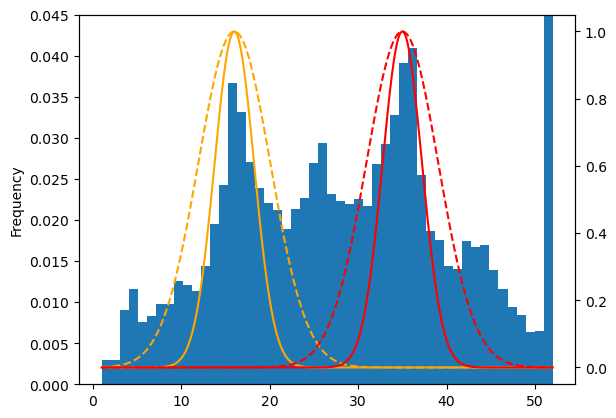

In [147]:
from sklearn.metrics.pairwise import rbf_kernel

# We want to different axis for the similarity function and histograma
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

# Create a dataframe for this example
df = pd.DataFrame(
    {"housing_median_age": housing["housing_median_age"]}, index=housing.index
)

# Plot the histogram
df["housing_median_age"].plot(kind="hist", bins=50, density=1, ax=ax1)
plt.xlabel("house age")
ax1.set_ylim([0, 0.045])

# We'll display the Gaussian RBF function for the two main nodes of the histogram
# Range where we want to compute the RBF
min = df["housing_median_age"].min()
max = df["housing_median_age"].max()
num_of_points = 1000
t = np.linspace(min, max, num_of_points)

# Mode 1: x = 15
x_0 = 16
# Using gamma = 0.10
gamma = 0.10
similarity = rbf_kernel(t.reshape(-1, 1), [[x_0]], gamma=gamma)
ax2.plot(t, similarity, color="orange")
# Using gamma = 0.03
gamma = 0.03
similarity = rbf_kernel(t.reshape(-1, 1), [[x_0]], gamma=gamma)
ax2.plot(t, similarity, color="orange", linestyle="--")

# Mode 2: x = 35
x_0 = 35
# Using gamma = 0.10
gamma = 0.10
similarity = rbf_kernel(t.reshape(-1, 1), [[x_0]], gamma=gamma)
ax2.plot(t, similarity, color="red")
# Using gamma = 0.03
gamma = 0.03
similarity = rbf_kernel(t.reshape(-1, 1), [[x_0]], gamma=gamma)
ax2.plot(t, similarity, color="red", linestyle="--")

#### Label transformation
